In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.calibration import CalibrationDisplay
import sys
import os

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))
from Basic_model import Centiles_plot, ROC_plot, cumulative_centiles_plot

In [2]:
def preprocessing(df):
    
    # On supprime les colonnes avec plus de 50% de NaN
    half_count = len(df) / 2
    df = df.dropna(thresh=half_count, axis=1)

    # Supprime les lignes avec des NaN
    df = df.dropna()

    # Colonnes One-Hot Encoding
    cols_to_encode = [
        'prd', 'team', 'shotCategory', 'shotBy', 'goalieName', 
        'visitorTeam', 'hostTeam', 'homeRinkSide', 
        'awayRinkSide', 'last_event_type'
    ]
    df = pd.get_dummies(df, columns=cols_to_encode)

    # Colonnes à binariser
    cols_to_binarize = ['noGoalie', 'rebond']
    for col in cols_to_binarize:
        df[col] = df[col].astype(int)

    # Supprime les colonnes redondantes
    cols_to_drop = ['gameId', 'evt_idx', 'prdTime']
    df = df.drop(cols_to_drop, axis=1)

    return df

In [3]:
df = pd.read_csv('../data/derivatives/dataframe_milestone_2.csv')

# données pour les saisons 2016/2017 à 2018/2019
df['season'] = df['gameId'].apply(lambda x: str(x)[:4])
df = df[df['season'].isin(['2016', '2017', '2018'])]

features = [
    'gameId', 'evt_idx', 'prd', 'prdTime', 'team', 'goalFlag', 'shotCategory', 
    'coord_x', 'coord_y', 'shotBy', 'goalieName', 'noGoalie', 'teamStrength', 
    'visitorTeam', 'hostTeam', 'homeRinkSide', 'awayRinkSide', 'last_event_type', 
    'last_event_x', 'last_event_y', 'time_since_last_event', 
    'distance_from_last_event', 'game_seconds', 'shot_distance', 'shot_angle', 
    'rebond', 'changement_angle_tir', 'vitesse'
]

#On binarise les labels
df['goalFlag'] = df['goalFlag'].astype(int)
y = df['goalFlag']
features.remove('goalFlag')
X = df[features]


In [4]:
X_preprocessed = preprocessing(X)

print("X_preprocessed length:", X_preprocessed.shape[0])
print("y length:", y.shape[0])

# Régularise le nombres de lignes d'entrées x (après preprocessing) avec le nombre de sorties y
if X_preprocessed.shape[0] != y.shape[0]:
    y = y.loc[X_preprocessed.index]

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

X_preprocessed length: 239474
y length: 253475
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     65296
           1       0.99      0.05      0.10      6547

    accuracy                           0.91     71843
   macro avg       0.95      0.53      0.52     71843
weighted avg       0.92      0.91      0.88     71843

ROC AUC Score: 0.7345789805750043


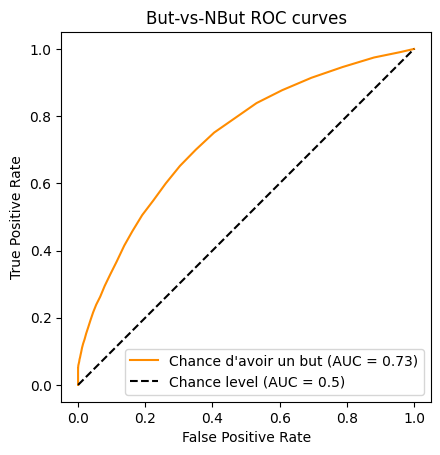

AUC metric : 0.7345789805750043


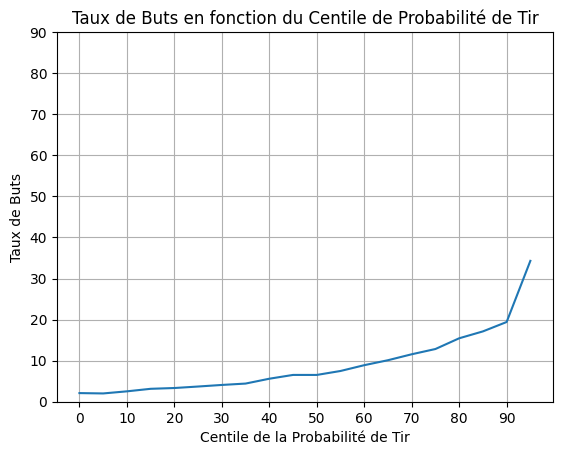

Text(0.5, 0.98, 'Courbe de Calibration pour le Modèle Random Forest')

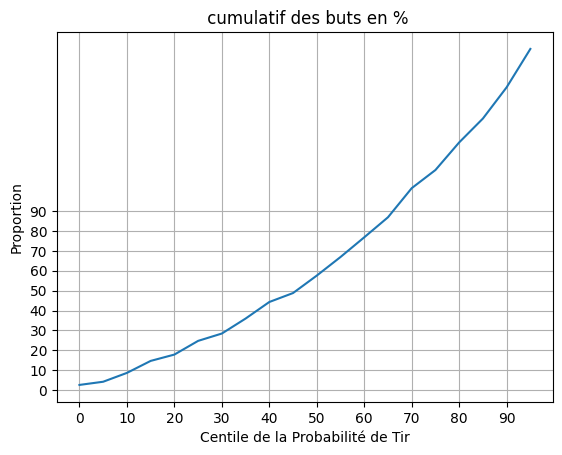

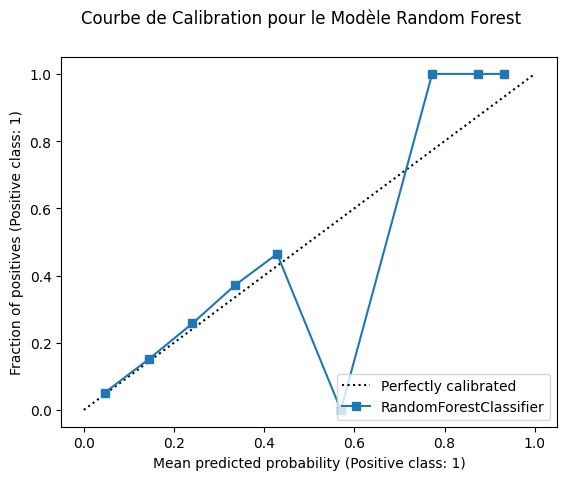

In [5]:

ROC_plot(y_test  , y_pred_proba)

Centiles_plot(y_test  , y_pred_proba)

cumulative_centiles_plot(y_test  , y_pred_proba)

calibration_display = CalibrationDisplay.from_estimator(clf, X_test, y_test, n_bins=10)
calibration_display.figure_.suptitle("Courbe de Calibration pour le Modèle Random Forest")